## Using PLUMED to do MetaDynamics

- Well tempered MetaD of torsion angle

In [1]:
# plumed_run_suffix
prs='t1wtmd'

In [2]:
!echo $prs\.dat
!echo "`echo $prs`.dat"
!echo "$prs\.dat"

t1wtmd.dat
t1wtmd.dat
t1wtmd\.dat


In [3]:
#Libraries and main variables initialized
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
import numpy as np
import urllib.request, json
import os
import re
import nglview as nv
from funcs import get_files_from_git
from funcs import view_nucl


import matplotlib.pyplot as plt

import MDAnalysis.analysis.pca as pca
import MDAnalysis.analysis.encore as encore
from MDAnalysis.analysis.rms import RMSF

from seq_tools.plot4seq import plot_prof4seq
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import seq1
from seq_tools.hist_ss import get_hist_ss_in_aln_for_shade
import numpy as np
import xvg_plot as xvg
import xpm_plot as xpm

#Reloading funcs if changed
from importlib import reload 
import funcs,config
reload(funcs)
reload(config)


%matplotlib inline
#%load_ext rpy2.ipython

from config import movtitle
from IPython.display import Markdown, display
from config import folder,descr,pname,ssh_host
display(Markdown(descr))
print("Folder set to: ",folder)
print("Project name: ",pname)
print("SSH host set to:",ssh_host)




# MD simulations of a tetrasome, 61 DNA bp, histone tails maximally truncated
- AMBER14SB force field with CUFIX
- 150 mM NaCl
- box 2nm


Folder set to:  h3-h4_tm_2_60DNA
Project name:  h3-h4_tm_2_60DNA
SSH host set to: lomo2k


### CVs should be tested in notebook 7_plumed....

### DNA angle, prepare CV and plumed file

In [6]:



import MDAnalysis as mda
import MDAnalysis.analysis.hbonds
import MDAnalysis.analysis.distances

#Let's load a structure with hydrogens, assumed the numbering is the same with full system, since water and ions are added to the end.
sys=mda.Universe("GMX_system/sys_ref.pdb")
#sys=mda.Universe("GMX_system/sys_ref.pdb",'big_data/sys_md.xtc')


#the chains have already been renamed by gromacs I=>A J=>B

sel_end1="(segid I and resnum -30 and (name N1 N3 N4 N6 N7 N9 C2 C4 C5 C6 C7 C8 C4 O2 O6)) or (segid J and resnum 30 and (name N1 N3 N4 N6 N7 N9 C2 C4 C5 C6 C7 C8 C4 O2 O6))"
sel_int1="(segid I and resnum -5 and (name N1 N3 N4 N6 N7 N9 C2 C4 C5 C6 C7 C8 C4 O2 O6)) or (segid J and resnum 5 and (name N1 N3 N4 N6 N7 N9 C2 C4 C5 C6 C7 C8 C4 O2 O6))"
sel_int2="(segid I and resnum 5 and (name N1 N3 N4 N6 N7 N9 C2 C4 C5 C6 C7 C8 C4 O2 O6)) or (segid J and resnum -5 and (name N1 N3 N4 N6 N7 N9 C2 C4 C5 C6 C7 C8 C4 O2 O6))"
sel_end2="(segid I and resnum 30 and (name N1 N3 N4 N6 N7 N9 C2 C4 C5 C6 C7 C8 C4 O2 O6)) or (segid J and resnum -30 and (name N1 N3 N4 N6 N7 N9 C2 C4 C5 C6 C7 C8 C4 O2 O6))"


E1=sys.select_atoms(sel_end1)
E2=sys.select_atoms(sel_end2)
I1=sys.select_atoms(sel_int1)
I2=sys.select_atoms(sel_int2)
#print(','.join([str(i.id) for i in E1.atoms]))

a=nv.show_mdanalysis(sys)
#a.clear_representations()
#a.add_representation('licorice',selection='all')
a.add_representation('spacefill',selection='@'+','.join([str(i.id-1) for i in E1.atoms]))
a.add_representation('spacefill',selection='@'+','.join([str(i.id-1) for i in E2.atoms]), color='magenta')
a.add_representation('spacefill',selection='@'+','.join([str(i.id-1) for i in I1.atoms]))
a.add_representation('spacefill',selection='@'+','.join([str(i.id-1) for i in I2.atoms]), color='magenta')
a.camera = 'orthographic'
a



NGLWidget()

In [37]:
from numpy.linalg import norm
#print("Initial angle =",Dihedral([E1,I1,I2,E2]),"")
end1at=','.join([str(i.id) for i in E1.atoms])
end2at=','.join([str(i.id) for i in E2.atoms])
int1at=','.join([str(i.id) for i in I1.atoms])
int2at=','.join([str(i.id) for i in I2.atoms])
chainIat=','.join([str(i.id) for i in sys.select_atoms("segid I").atoms])
chainJat=','.join([str(i.id) for i in sys.select_atoms("segid J").atoms])


#Now let's write a plumed.dat file
#NOTE: wholemolecules and NOPBC are crucial!!!

!echo "WHOLEMOLECULES ENTITY0=$chainIat ENTITY1=$chainJat" >GMX_run/plumed_$prs\.dat
!echo "end1: GROUP ATOMS=$end1at" >>GMX_run/plumed_$prs\.dat
!echo "end2: GROUP ATOMS=$end2at" >>GMX_run/plumed_$prs\.dat
!echo "int1: GROUP ATOMS=$int1at" >>GMX_run/plumed_$prs\.dat
!echo "int2: GROUP ATOMS=$int2at" >>GMX_run/plumed_$prs\.dat
!echo "com_end1: COM ATOMS=end1" >>GMX_run/plumed_$prs\.dat
!echo "com_end2: COM ATOMS=end2" >>GMX_run/plumed_$prs\.dat
!echo "com_int1: COM ATOMS=int1" >>GMX_run/plumed_$prs\.dat
!echo "com_int2: COM ATOMS=int2" >>GMX_run/plumed_$prs\.dat
!echo "t1: TORSION ATOMS=com_end1,com_int1,com_int2,com_end2 NOPBC" >>GMX_run/plumed_$prs\.dat
!echo "uwall: UPPER_WALLS ARG=t1 AT=0.6 KAPPA=150.0 EXP=4 EPS=0.05 OFFSET=0" >>GMX_run/plumed_$prs\.dat
!echo "lwall: LOWER_WALLS ARG=t1 AT=-0.6 KAPPA=150.0 EXP=4 EPS=0.05 OFFSET=0" >>GMX_run/plumed_$prs\.dat

!cp GMX_run/plumed_$prs\.dat GMX_run/plumed_$prs\_MD.dat #multiple walkers verion for multidir option in GROMACS

!echo "meta: METAD ARG=t1 SIGMA=0.05 BIASFACTOR=10.0 TEMP=300.0  HEIGHT=1 PACE=500 FILE=HILLS_`echo $prs`.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>GMX_run/plumed_$prs\.dat
!echo "PRINT ARG=t1,uwall.bias,lwall.bias FILE=colvar_`echo $prs`.dat STRIDE=500" >>GMX_run/plumed_$prs\.dat

!echo "meta: METAD ARG=t1 SIGMA=0.05 BIASFACTOR=10.0 TEMP=300.0  HEIGHT=1 PACE=500 FILE=../HILLS_`echo $prs`.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>GMX_run/plumed_$prs\_MD.dat
!echo "PRINT ARG=t1,uwall.bias,lwall.bias FILE=../colvar_`echo $prs`.dat STRIDE=500" >>GMX_run/plumed_$prs\_MD.dat


#UPPER_WALLS ARG=d1,d2 AT=1.0,1.5 KAPPA=150.0,150.0 EXP=2,2 EPS=1,1 OFFSET=0,0 LABEL=uwall
#LOWER_WALLS ARG=d1,d2 AT=0.0,1.0 KAPPA=150.0,150.0 EXP=2,2 EPS=1,1 OFFSET=0,0 LABEL=lwall


#!echo "PRINT ARG=t1 FILE=colvar.dat STRIDE=10" >>GMX_run/plumed_t1.dat
!cat GMX_run/plumed_$prs\_MD.dat



WHOLEMOLECULES ENTITY0=1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,2

## Prepare new tpr-file!

In [38]:
# !cp GMX_run/7_prod.tpr GMX_run/plumed_$prs\_7_prod.tpr
# !cp GMX_run/7_prod_10ps_out.tpr GMX_run/plumed_$prs\_7_prod_10ps_out.tpr

In [69]:
%%bash -s "$prs" 
for i in `seq 0 15`; do
mkdir -p GMX_run/$i
cp GMX_run/7_prod_$i.tpr GMX_run/$i/plumed_$1\_7_prod.tpr
cp GMX_run/plumed_$1\_MD.dat GMX_run/$i/
done

# =============Run=============

In [48]:
%%bash -s "$prs" 
#Local run
#cd GMX_run
#mpirun -np 1  mdrun_mpi -ntomp 10 -deffnm plumed_7_prod -plumed plumed_t1.dat 
#mpirun -np 1  mdrun_mpi -ntomp 10 -deffnm plumed_7_prod_10ps_out -plumed plumed_t1.dat 
#mpirun -np 4 mdrun_mpi -ntomp 10 -deffnm plumed_7_prod_10ps_out_walker -plumed plumed_t1.dat -multi 4
echo "mpirun -np 4 mdrun_mpi -ntomp 8 -deffnm plumed_${1}_7_prod -plumed plumed_${1}_MD.dat -multidir `seq -s ' ' 0 3`"




mpirun -np 4 mdrun_mpi -ntomp 8 -deffnm plumed_t1wtmd_7_prod -plumed plumed_t1wtmd_MD.dat -multidir 0 1 2 3


In [16]:
#Run on Lomonosov
#Transfer
!ssh $ssh_host "mkdir -p ~/_scratch/$folder"
!cp Run_scripts/lomo2_run_plumed.sh GMX_run/
!cp Run_scripts/lomo2_run_plumed_multi.sh GMX_run/
#!cp Run_scripts/lomo2_run_cont_plumed.sh GMX_run/
!rsync --dry-run --update --progress --exclude '*.xtc' --exclude '*.trr' --exclude 'step*' -r GMX_run $ssh_host:~/_scratch/$folder/;
# !rsync --update --progress --exclude '*.xtc' --exclude '*.trr' --exclude 'step*' -r GMX_run $ssh_host:~/_scratch/$folder/;






   Lomonosov-2 supercomputer welcomes you!


   Lomonosov-2 supercomputer welcomes you!




In [154]:
%%bash -s "$folder" "$ssh_host" 
#Launching initially!!!
#ssh $2 "source /etc/profile; export MODULEPATH=\$MODULEPATH:/home/satary_1609/_scratch/_software/modules; module load slurm gromacs_2019.2_plumed; cd ~/_scratch/$1/GMX_run; sbatch -p compute -t 1-00:00:00 -N 4 -J plumed_$1 lomo2_run_plumed.sh plumed_7_prod plumed_t1.dat"



In [17]:
%%bash -s "$folder" "$ssh_host" "$prs"
#Launching initially MULTI!!!
ssh $2  "source /etc/profile; export MODULEPATH=\$MODULEPATH:/home/satary_1609/_scratch/_software/modules; module load slurm gromacs_2019.2_plumed; cd ~/_scratch/$1/GMX_run; sbatch -p compute -t 7-00:00:00 -N 16 -J plumed_`echo $3`_$1 lomo2_run_plumed_multi.sh plumed_`echo $3`_7_prod plumed_`echo $3`_MD.dat 16"





Submitted batch job 1063961


   Lomonosov-2 supercomputer welcomes you!




In [4]:
!ssh $ssh_host "module load slurm gromacs/2018-gcc; squeue -u \`whoami\` " || echo "No job in queue"

   Lomonosov-2 supercomputer welcomes you!


             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1064244   compute   unwrap kniazeva PD       0:00     10 (Resources)
           1063552   compute   unwrap kniazeva  R 1-08:49:34     10 n[51505-51506,51727-51728,52027-52028,52713-52714,53019-53020]
           1063960   compute plumed_m kniazeva  R    7:50:21     16 n[48109-48110,48508-48509,48705-48706,49218-49220,49527-49528,49707-49708,53606-53608]
           1063961   compute plumed_t kniazeva  R    5:35:03     16 n[48116,48318,49202,49214,49317,49322,49504,49629-49630,50103,50114-50115,50220-50221,53015-53016]


In [122]:
!ssh $ssh_host "module load slurm gromacs/2018-gcc; scancel 1063275"

   Lomonosov-2 supercomputer welcomes you!




In [32]:
!ssh $ssh_host "module load slurm gromacs/2018-gcc; squeue -n plumed_$folder " || echo "No job in queue"


   Lomonosov-2 supercomputer welcomes you!


             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


   Lomonosov-2 supercomputer welcomes you!


             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [ ]:
%%bash -s "$folder" "$ssh_host" 
#Relaunch - FIXES FOR MULTIDIR ARE NEEDED
#ssh $2 "source /etc/profile; export MODULEPATH=\$MODULEPATH:/home/satary_1609/_scratch/_software/modules; module load slurm gromacs_2019.2_plumed; cd ~/_scratch/$1/GMX_run; sbatch -p compute -t 7-00:00:00 -N 4 -J plumed_$1 lomo2_run_plumed_cont.sh plumed_7_prod plumed_a1.dat"

#Relaunch for non-plumed runs
##!ssh $ssh_host "module load slurm gromacs/2018-gcc; cd ~/_scratch/$folder/GMX_run; sbatch -p compute -t 7-00:00:00 -N 4 -J $folder lomo2_run_cont.sh 7_prod"

In [ ]:
%%bash -s "$folder" "$ssh_host" 
#Make a chain of tasks
#set --dependency=afterany:970076
#ssh $2 "source /etc/profile; export MODULEPATH=\$MODULEPATH:/home/satary_1609/_scratch/_software/modules; module load slurm gromacs_2019.2_plumed; cd ~/_scratch/$1/GMX_run; sbatch -p compute -t 7-00:00:00 -N 4 -J plumed_$1 --dependency=afterany:970076 lomo2_run_plumed_cont.sh plumed_7_prod plumed_a1.dat"


In [198]:
#Check status
!ssh $ssh_host "tail -n 50 ~/_scratch/$folder/GMX_run/plumed_7_prod.log | grep -A1 Time"

   Lomonosov-2 supercomputer welcomes you!


           Step           Time
       27079000    54158.00000
--
           Step           Time
       27080000    54160.00000
--
           Step           Time
       27081000    54162.00000


In [205]:
%%bash -s "$folder" "$ssh_host" --err err --out out
#Get back data

rsync --partial --update --progress $2:~/_scratch/$1/GMX_run/plumed_7_prod* GMX_run/ ;
rsync --partial --update --progress $2:~/_scratch/$1/GMX_run/HILL* GMX_run/ ;
rsync --partial --update --progress $2:~/_scratch/$1/GMX_run/egmx* GMX_run/ ;    
rsync --partial --update --progress $2:~/_scratch/$1/GMX_run/ogmx* GMX_run/ ;      

In [5]:
%%bash -s "$folder" "$ssh_host" "$prs" --err err --out out
#Get back data

rsync --partial --update --progress $2:~/_scratch/$1/GMX_run/HILL* GMX_run/ ;
rsync --partial --update --progress $2:~/_scratch/$1/GMX_run/colvar* GMX_run/ ;
rsync --partial --update --progress $2:~/_scratch/$1/GMX_run/egmx* GMX_run/ ;    
rsync --partial --update --progress $2:~/_scratch/$1/GMX_run/ogmx* GMX_run/ ; 

for i in `seq 0 15`; do
rsync --partial --update --progress $2:~/_scratch/$1/GMX_run/$i/plumed_`echo $3`_7_prod* GMX_run/$i/ ;
done




## ==========Analysis========

In [6]:
#Preprocees trj
#!./5_trj_preprocessing.sh plumed_7_prod_10ps_out plumed_md
# !./5_trj_preprocessing.sh plumed_7_prod_10ps_out_walker3 plumed_md
!mkdir -p tmp/0
!./5_trj_preprocessing.sh 0/plumed_$prs\_7_prod plumed_md

gmx: Relink `/opt/miniconda3/envs/moldyn/bin/../lib/././libgfortran.so.4' with `/lib/x86_64-linux-gnu/librt.so.1' for IFUNC symbol `clock_gettime'
                     :-) GROMACS - gmx trjconv, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess

gmx: Relink `/opt/miniconda3/envs/moldyn/bin/../lib/././libgfortran.so.4' with `/lib/x86_64-linux-gnu/librt.so.1' for IFUNC symbol `clock_gettime'
                     :-) GROMACS - gmx trjconv, 2018.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess

In [19]:
view_nucl('GMX_system/sys_ref.pdb','big_data/plumed_md.xtc')

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=2)

#! FIELDS time t1 sigma_t1 height biasf
#! SET multivariate false
#! SET kerneltype gaussian
#! SET min_t1 -pi
#! SET max_t1 pi
      1.000000047497451    -0.2466561607676327                   0.05      1.111111111111111                     10
      1.000000047497451    -0.2593365626544122                   0.05      1.111111111111111                     10
      1.000000047497451    -0.2465443628385682                   0.05      1.111111111111111                     10
      1.000000047497451    -0.2537316496764852                   0.05      1.111111111111111                     10
      1.000000047497451    -0.2669210685915813                   0.05      1.111111111111111                     10
Labels found: ['time', 't1', 'sigma_t1', 'height', 'biasf']


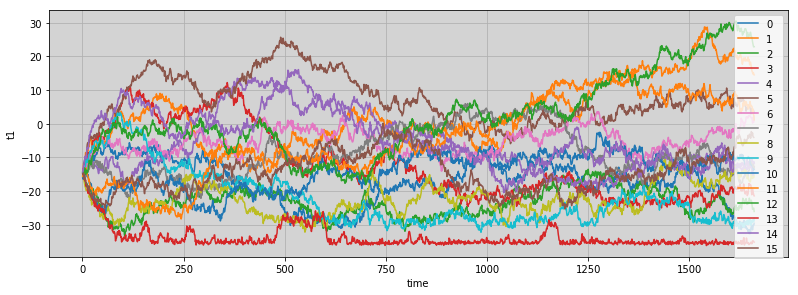

Labels found: ['time', 't1', 'sigma_t1', 'height', 'biasf']


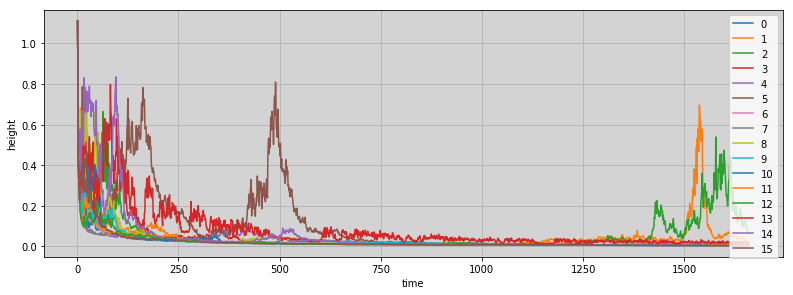

In [14]:
from importlib import reload 
import funcs
reload(funcs)
from funcs import plot_plumed
import numpy as np
%matplotlib inline
!head -n -2 GMX_run/HILLS_$prs\.dat > GMX_run/HILLS_$prs\r.dat
!head GMX_run/HILLS_$prs\r.dat
d=plot_plumed('GMX_run/HILLS_%sr.dat'%prs,figsize=(15,5),col2plot=[1],multi=16,ymult=180./3.1415)
d=plot_plumed('GMX_run/HILLS_%sr.dat'%prs,figsize=(15,5),col2plot=[3],multi=16)

#! FIELDS time t1 uwall.bias lwall.bias
#! SET min_t1 -pi
#! SET max_t1 pi
 0.000000 -0.261357 0.000000 0.000000
 1.000000 -0.246656 0.000000 0.000000
 2.000000 -0.233781 0.000000 0.000000
 3.000000 -0.231213 0.000000 0.000000
 4.000000 -0.226249 0.000000 0.000000
 5.000000 -0.219283 0.000000 0.000000
 6.000000 -0.198188 0.000000 0.000000
Labels found: ['time', 't1', 'uwall.bias', 'lwall.bias']


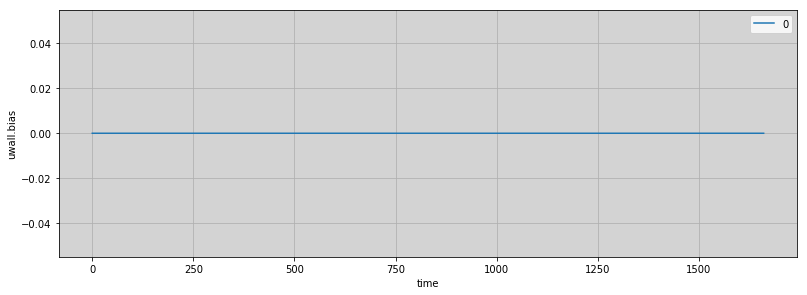

Labels found: ['time', 't1', 'sigma_t1', 'height', 'biasf']


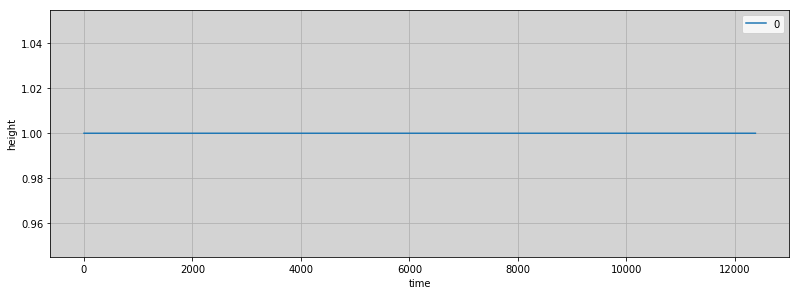

In [9]:
!head GMX_run/colvar_$prs\.0.dat
d=plot_plumed('GMX_run/colvar_%s.0.dat'%prs,figsize=(15,5),col2plot=[2])
d=plot_plumed('GMX_run/HILLS_t1r.dat',figsize=(15,5),col2plot=[3])

In [10]:
#Comparing what we get with the reference
from funcs import plot_plumed
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

!mkdir -p big_data
!mkdir -p big_data/sh
stride=10*16
!plumed sum_hills --stride $stride  --hills GMX_run/HILLS_$prs\.dat --outfile big_data/sh/sumhills_$prs\.dat --mintozero >/dev/null
!head big_data/sh/sumhills_$prs\.dat0.dat

d=plot_plumed('GMX_run/HILLS_%sr.dat'%prs,figsize=(20,5),col2plot=[1],plot=False,multi=4) 
#d=plot_plumed('GMX_run/HILLS_a1r.dat',figsize=(20,5),col2plot=[3]) 



sum_df=pd.DataFrame()



# plt.figure(figsize=(10,10))
# plt.xlim(-0.6*180./3.1415,0.6*180./3.1415)
# plt.ylim(0,50)
maxtime=int(len(d)/stride)
print("Maxtime=",maxtime)
for i in range(int(len(d)/stride)):
    data=plot_plumed('big_data/sh/sumhills_%s.dat%d.dat'%(prs,i),plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df=df.loc[(df['angle']<0.6) & (df['angle']>-0.6)]
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
#     plt.plot(df['angle'],df['energy'],linewidth=2,label='_nolegend_')
#     plt.plot(df['angle']*180./3.1415,df['energy']/2.5,linewidth=2)



#! FIELDS t1 file.free der_t1
#! SET min_t1 -pi
#! SET max_t1 pi
#! SET nbins_t1  86
#! SET periodic_t1 true
   -3.141592654   50.564862704   -0.000000000
   -3.068532359   50.564862704   -0.000000000
   -2.995472065   50.564862704   -0.000000000
   -2.922411771   50.564862704   -0.000000000
   -2.849351477   50.564862704   -0.000000000
Labels found: ['time', 't1', 'sigma_t1', 'height', 'biasf']
Maxtime= 165


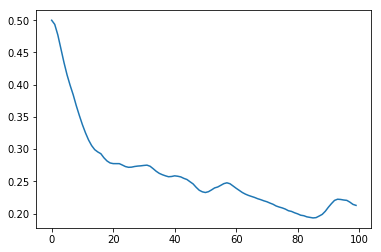

In [86]:
# from scipy.stats import pearsonr

# a=np.array([1,1,1,8])
# b=np.array([2,2,3,9])
# acf=[]
# for i in range(100):
#     cc=[]
#     for k in range(maxtime-i):
#         cc.append(pearsonr(sum_df.loc[sum_df['Time']==k,'energy'],sum_df.loc[sum_df['Time']==k+i,'energy']))
#     cc=np.array(cc)
#     acf.append(cc.mean())    

# # pearsonr(a,b)
# plt.plot(acf)

#! FIELDS t1 file.free der_t1
#! SET min_t1 -pi
#! SET max_t1 pi
#! SET nbins_t1  86
#! SET periodic_t1 true
   -3.141592654   98.601174011   -0.000000000
   -3.068532359   98.601174011   -0.000000000
   -2.995472065   98.601174011   -0.000000000
   -2.922411771   98.601174011   -0.000000000
   -2.849351477   98.601174011   -0.000000000
Labels found: ['time', 't1', 'sigma_t1', 'height', 'biasf']
Maxtime= 5


Text(0, 0.5, 'Energy, kT')

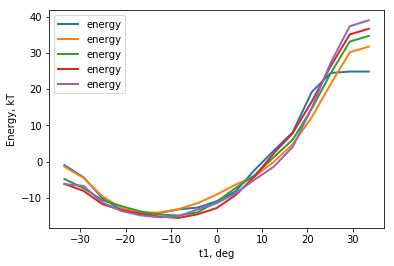

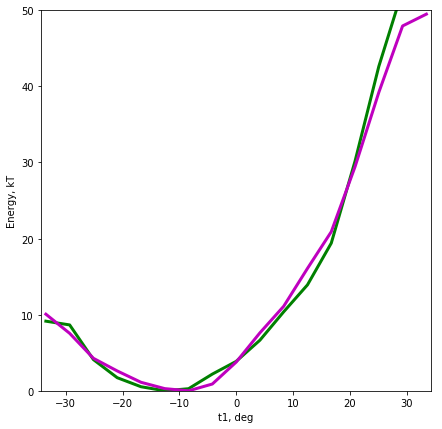

In [15]:
#Comparing what we get with the reference
from funcs import plot_plumed
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

!mkdir -p big_data
!mkdir -p big_data/sh
stride=10*16*30
!plumed sum_hills --stride $stride  --hills GMX_run/HILLS_$prs\r.dat --outfile big_data/sh/sumhills_$prs\.dat --mintozero >/dev/null
!head big_data/sh/sumhills_$prs\.dat0.dat

d=plot_plumed('GMX_run/HILLS_%sr.dat'%prs,figsize=(20,5),col2plot=[1],plot=False,multi=4) 
#d=plot_plumed('GMX_run/HILLS_a1r.dat',figsize=(20,5),col2plot=[3]) 



sum_df=pd.DataFrame()



# plt.figure(figsize=(10,10))
# plt.xlim(-0.6*180./3.1415,0.6*180./3.1415)
# plt.ylim(0,50)
maxtime=int(len(d)/stride)
print("Maxtime=",maxtime)
for i in range(int(len(d)/stride)):
    data=plot_plumed('big_data/sh/sumhills_%s.dat%d.dat'%(prs,i),plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df=df.loc[(df['angle']<0.6) & (df['angle']>-0.6)]
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
#     plt.plot(df['angle'],df['energy'],linewidth=2,label='_nolegend_')
    plt.plot(df['angle']*180./3.1415,df['energy']/2.5,linewidth=2)




plt.legend()
plt.xlabel('t1, deg')
plt.ylabel('Energy, kT')
plt.figure(figsize=(7,7))
plt.ylim(0,50)
# plt.plot(df['angle']*180./3.1415,(df['energy']-df['energy'].min())/2.5,'b-',linewidth=4)
#plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=4)
plt.xlim(-0.6*180./3.1415,0.6*180./3.1415)

df_avr_n=sum_df.loc[sum_df['Time']==sum_df['Time'].max()].groupby('angle', as_index=False).energy.mean()
plt.plot(df_avr_n['angle']*180./3.1415,(df_avr_n['energy']-df_avr_n['energy'].min())/2.5,'g-',linewidth=3)

df_avr_n1=sum_df.loc[sum_df['Time']==sum_df['Time'].max()/2].groupby('angle', as_index=False).energy.mean()
plt.plot(df_avr_n1['angle']*180./3.1415,(df_avr_n1['energy']-df_avr_n1['energy'].min())/2.5,'m-',linewidth=3)

# df_avr_n2=sum_df.loc[sum_df['Time']>sum_df['Time'].max()/2].groupby('angle', as_index=False).energy.mean()
# plt.plot(df_avr_n2['angle']*180./3.1415,(df_avr_n2['energy']-df_avr_n2['energy'].min())/2.5,'c-',linewidth=3)



plt.xlabel('t1, deg')
plt.ylabel('Energy, kT')


